# Lab 4, Part 1

## Units of variables given in the dataset:
* elevation: meters above sea level
* g: mm water equivalent per meter (db/dz)
* continentality: degrees Celsius
* cloud cover: percentage
* summer temperature: degrees Celsius
* precipitation: mm per year
* average winter precipitation: mm per month 

> NOTE: climate variables are given from climatological gridded data (CRU) provided for the whole globe on ca 50x50 km grid

## Variables:

```
                       g: [1x136 double]  glacier mass balance gradient (as an average over the observed period)
        median_elevation: [1x136 double]  Median glacier elevation (derived from glacier hypsometry: glacier area vs elevation)
      summer_temperature: [1x136 double]  Summer near-surface air temperature over a grid cell (ca 50x50 km) covering the glacier (averaged over the observed period)
           precipitation: [1x136 double]  Total annaul precipitation over a grid cell (ca 50x50 km) covering the glacier (averaged over the observed period)
                     lat: [1x136 double]  Geographical latitude of the glacier (in degrees)
           max_elevation: [1x136 double]  Maximum glacier elevation
                 WGMS ID: [1x136 int64]   Given glacier ID (from World Glacier Monitoring Service)
    winter_precipitation: [1x136 double]  Same as for precipation but derived only over winter months 
                     lon: [1x136 double]  Geographical longitude of the glacier (in degrees)
             cloud_cover: [1x136 double]  Annual cloud cover over a grid cell (ca 50x50 km) covering the glacier (averaged over the observed period)
          continentality: [1x136 double]  Maximum monthly temperature minus minimum monthly temperature over a year (over a grid cell covering the glacier and averaged over the observed period). The larger the continentality index the climate is more continental (rather than maritime). 
```


In [1]:
#import all required libraries etc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import ipywidgets

#NOTE: to get ipywidgets to work, need to enter the following into the command line:
#    conda install -c conda-forge ipywidgets
#    conda install -c conda-forge nodejs
#    jupyter lab --version
#Based on the version of jupyter lab, check https://npm.taobao.org/package/@jupyter-widgets/jupyterlab-manager for next command
#The final command should look something like:
#    jupyter labextension install @jupyter-widgets/jupyterlab-manager@1.0
#where the -manager@XX changes based on the version of jupyter that you have

In [2]:
# load the data and check it out
data = pd.read_csv('glaciers.csv')
data.head()

,g,median_elevation,summer_temperature,precipitation,lat,max_elevation,winter_precipitation,lon,cloud_cover,continentality
0,8.102728,1071.00,7.626667,483.990,-54.78,1172.5,36.273333,-68.40,63.393750,8.395
1,1.860170,2660.00,11.663333,1637.810,47.04,2950.0,91.578333,12.97,61.731667,18.830
2,9.194071,2560.00,14.881667,1521.845,47.48,2910.0,83.785000,13.62,61.529583,20.045
3,4.162200,3039.75,11.683333,1550.760,46.80,3715.5,93.790000,10.77,62.957083,18.725
4,4.411077,2795.00,10.561667,1726.480,46.85,3140.0,110.065000,10.15,64.265417,17.855


In [3]:
# clean data -- g<0 is non physical and this data point should be removed
data = data.drop(np.argwhere(data['g']<0)[0])

/Users/robertlin/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


In [4]:
# normalize data and check it out

data_norm = (data - data.mean())/data.std()
data_norm.head()

,g,median_elevation,summer_temperature,precipitation,lat,max_elevation,winter_precipitation,lon,cloud_cover,continentality
0,0.729295,-1.127617,-0.610002,-1.008986,-4.510634,-1.305564,-0.826765,-0.917411,-0.073330,-1.567918
1,-1.252792,0.077903,0.303656,0.634920,-0.009790,0.000761,0.080425,0.221562,-0.285946,-0.270948
2,1.075809,0.002036,1.032093,0.469699,0.009659,-0.028636,-0.047412,0.230660,-0.311797,-0.119936
3,-0.521870,0.366006,0.308183,0.510896,-0.020399,0.563344,0.116703,0.190768,-0.129189,-0.283999
4,-0.442849,0.180323,0.054305,0.761253,-0.018189,0.140396,0.383669,0.182089,0.038174,-0.392131


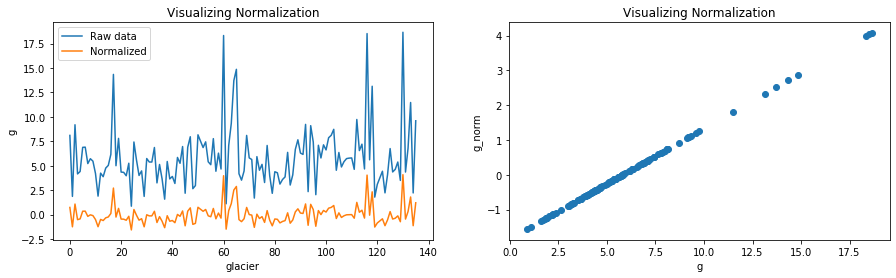

In [5]:
# visualize normalization
plt.figure(figsize=[15,4])

plt.subplot(1,2,1)
plt.plot(data['g'])
plt.plot(data_norm['g'])
plt.legend(['Raw data','Normalized'])
plt.ylabel('g')
plt.xlabel('glacier')
plt.title('Visualizing Normalization')

plt.subplot(1,2,2)
plt.scatter(data['g'],data_norm['g'])
plt.ylabel('g_norm')
plt.xlabel('g')
plt.title('Visualizing Normalization')

plt.show()

In [6]:
# unpack normalized data
lat = data_norm['lat']
lon = data_norm['lon']
hmax = data_norm['max_elevation']
hmed = data_norm['median_elevation']
g = data_norm['g']
Pannual = data_norm['precipitation']
Pwinter = data_norm['winter_precipitation']
CI = data_norm['continentality']
cloud = data_norm['cloud_cover']
Tsummer = data_norm['summer_temperature']

## Question 1

What are the most characteristic features in the space of these variables across the glaciers? Apply PCA on the data with 10 variables and 136 observations to find out! Eigenvectors (which carry most of the variance) will represent the characteristic features.

> Hint: m=10, n=136 $\implies$ you have a data with 10 dimensions and 136 samples

First, run principal component analysis:

In [7]:
n_modes = np.shape(data_norm)[1]
pca = PCA(n_components = n_modes)
pcs = pca.fit_transform(data_norm)       # principal components (135 x 10, ie {observations} x {variables}, where each component has length {variables})
eigvecs = pca.components_                # our component eigenvectors (10 x 10, ie each row is an eigenvector)
frac_var = pca.explained_variance_ratio_ # fractional variance (10 x 1, ie one variance measurement for each feature)

Verify that the output of PCA has the expected dimensions. Note that:

* `np.shape` outputs a tuple of `(n_rows: int, n_columns: int)`
* `pca.fit_transform` returns a matrix where each *column* is a principal component encompassing all samples, i.e. the *rows* represent the observations

In [15]:
n_obs = np.shape(data_norm)[0]  # number of observations (images)
n_vars = np.shape(data_norm)[1] # number of pixels in each image (i.e. the number of variables that defines each observation)
print('We have %d observations, %d variables' % (n_obs, n_vars))

print('Expected sizes:')
print('\t' + str(n_vars) + ' eigenvectors, each of length ' + str(n_vars))
print('\t' + str(n_vars) + ' eigenvalues, one for each eigenvector')
print('\t' + str(n_vars) + ' PCs, each of length ' + str(n_obs))

print('Actual sizes:')
print('\t' + str(np.shape(eigvecs)[0]) + ' eigenvectors, each of length ' + str(np.shape(eigvecs)[1]))
print('\t' + str(len(frac_var)) + ' eigenvalues')
print('\t' + str(np.shape(pcs)[1]) + ' PCs, each of length ' + str(np.shape(pcs)[0]))

We have 135 observations, 10 variables
Expected sizes:
	10 eigenvectors, each of length 10
	10 eigenvalues, one for each eigenvector
	10 PCs, each of length 135
Actual sizes:
	10 eigenvectors, each of length 10
	10 eigenvalues
	10 PCs, each of length 135


Take a look at the variance explained by each mode.

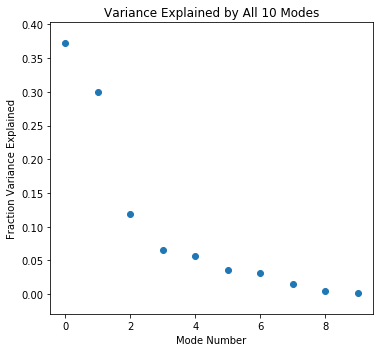


First 3 modes explain 79.028% of the variance!


In [34]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(range(len(frac_var)), frac_var)
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('Variance Explained by All %d Modes' % len(frac_var))

plt.tight_layout()
plt.show()

n_modes = 3
print('\nFirst %d modes explain %.3f%% of the variance!' % (n_modes, 100 * sum(frac_var[:3])))

Since the first 3 modes explain a good percentage of the variance, let's take a closer look:

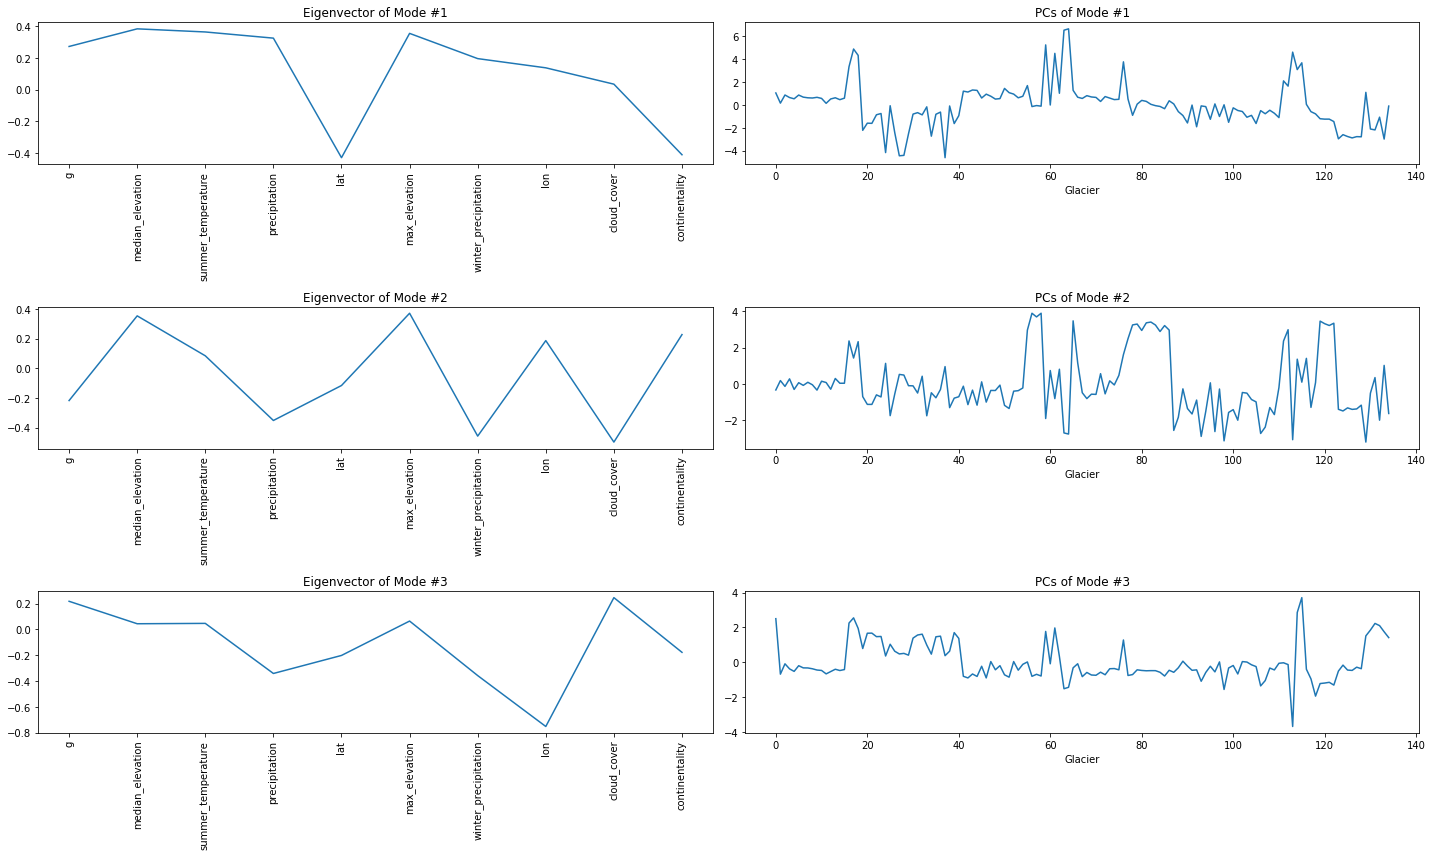

In [33]:
plt.figure(figsize=(20, 4*n_modes))
for mode_id in range(n_modes):
    plt.subplot(n, 2, (mode_id*2)+1)
    plt.plot(
        list(data_norm.columns), # print out the name of each feature
        eigvecs[mode_id, :],     # plot the mode_id^th row, each element of which gives value of a feature
    )
    plt.xticks(rotation=90)
    plt.title('Eigenvector of Mode #' + str(mode_id+1))

    plt.subplot(n, 2, (mode_id+1)*2)
    plt.plot(pcs[:, mode_id]) # take the mode_id^th column
    plt.title('PCs of Mode #' + str(mode_id+1))
    plt.xlabel('Glacier')
    plt.tight_layout()

Now we want to **reconstruct** the data and **measure the error** (using [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation)), defined as:

$$
\sqrt{\small\sum e^2}
$$

Recall that using PCA we get the following approximation for reconstruction:

$$
\text{Observation #1} \approx \sum_{j=1}^{\texttt{n_modes}} a_{1,j} \times \overline{v_j} 
$$

In [48]:
# reconstruct our dataset
data_rec = np.empty_like(data_norm)
for obs_id in range(n_obs):
    # in this case, each observation has 10 features
    reconstructed_obs = np.zeros_like(data_norm.iloc[0,:])
    # reconstruct each feature using just the modes
    for mode in range(n_modes):
        reconstructed_obs += eigvecs[mode, :] * pcs[obs_id, mode]
    # update row (observation) in reconstructed data
    data_rec[obs_id, :] = reconstructed_obs

# calculate error
error = data_norm - data_rec
rmse = np.sqrt(np.sum(error**2,axis=1) / 32 / 32) # TODO: why 32?
min_rmse = np.min(rmse)
min_rmse_index = np.argsort(rmse)
print('Minimum RMSE: %d' % min_rmse)
sorted_rmse = np.sort(rmse)
sorted_rmse_index = np.argsort(rmse,axis=0)

Minimum RMSE: 0


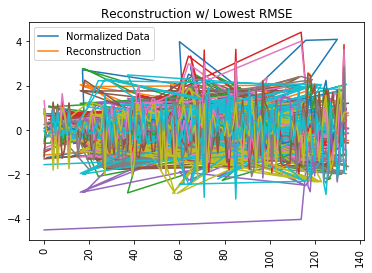

In [49]:
plt.plot(data_norm.iloc[min_rmse_index,:])
plt.plot(data_rec[min_rmse_index,:])
plt.legend(['Normalized Data','Reconstruction'])
plt.title('Reconstruction w/ Lowest RMSE')
plt.xticks(rotation=90)
plt.show()